## Dependencies

In [ ]:
import os
import shutil
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

## Data Download

In [ ]:
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

In [ ]:
!mkdir -p video_data test_train_splits
!unrar e test_train_splits.rar test_train_splits
!rm test_train_splits.rar
!unrar e hmdb51_org.rar 
!rm hmdb51_org.rar
!mv *.rar video_data

import os

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
        os.system("mkdir -p video_data/" + foldername)
        os.system("unrar e video_data/"+ files + " video_data/"+foldername)

!rm video_data/*.rar

## Data Preprocess & Split

In [5]:
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('HMDB51/test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

## Obtain Frames (middle)

In [37]:
# Loop over all categories/classes and extract random frame
for category in keep_hmdb51:
    # set the path to the directory containing the videos
    video_dir = f'new_HMDB51/video_data/{category}'

    # get a list of all .avi files in the directory
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.avi')]

    # iterate over each video file
    for video_file in video_files:

        video_path = os.path.join(video_dir, video_file)
        video = cv2.VideoCapture(video_path)
        num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        # obtain the middle frame
        frame_num = num_frames//2

        # set the frame number to read
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = video.read()
        video.release()
        if ret:
            
            path = f'new_HMDB51/frames/middle/{category}'
            os.makedirs(path, exist_ok=True)
            # set the path to save the image
            img_path = os.path.join(path, os.path.splitext(video_file)[0] + '.jpg')

            # save the image
            cv2.imwrite(img_path, frame)
        
        else:
            print('Unable to extract frame!')

## Data Load

In [8]:
x_train = []
x_test = []

for file in train_files:
    vid_name = file[:-4]
    for path, _, files in os.walk('new_HMDB51/frames/middle'):
        for file_name in files:
            if file_name[:-4] == vid_name:
                img = cv2.imread(os.path.join(path, file_name))
                img = cv2.resize(img, (112, 112))
                x_train.append(img)
                
for file in test_files:
    vid_name = file[:-4]
    for path, _, files in os.walk('new_HMDB51/frames/middle'):
        for file_name in files:
            if file_name[:-4] == vid_name:
                img = cv2.imread(os.path.join(path, file_name))
                img = cv2.resize(img, (112, 112))
                x_test.append(img)
                
x_train = np.asarray(x_train)/255.
x_test = np.asarray(x_test)/255.

In [9]:
# Dict to convert string labels to ints
str_to_int = {"clap":0, "climb":1, "drink":2, "jump":3, "pour":4, "ride_bike":5, "ride_horse":6, 
              "run":7, "shoot_bow":8, "smoke":9, "throw":10, "wave":11}

y_train = np.array([str_to_int[label] for label in train_labels])
y_test = np.array([str_to_int[label] for label in test_labels])

## Load Stanford40 CNN

In [ ]:
# Baseline from Assignment 4
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(112, 112, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=12, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load weights from Stanford dataset
model.load_weights('weights/stanford.h5')

# Freeze the convolutional layers of the model
model.layers[0].trainable = False
model.layers[2].trainable = False
model.layers[4].trainable = False

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

## Fine-tuning

In [11]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2023-04-15 20:19:01.065803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 126443520 exceeds 10% of free system memory.


27/27 [==============================] - 11s 365ms/step - loss: 3.2968 - accuracy: 0.2131
Epoch 2/10
27/27 [==============================] - 10s 384ms/step - loss: 2.0071 - accuracy: 0.3476
Epoch 3/10
27/27 [==============================] - 11s 418ms/step - loss: 1.6837 - accuracy: 0.4595
Epoch 4/10
27/27 [==============================] - 10s 383ms/step - loss: 1.3560 - accuracy: 0.5679
Epoch 5/10
27/27 [==============================] - 11s 403ms/step - loss: 1.0218 - accuracy: 0.6857
Epoch 6/10
27/27 [==============================] - 10s 388ms/step - loss: 0.7408 - accuracy: 0.7679
Epoch 7/10
27/27 [==============================] - 11s 392ms/step - loss: 0.5360 - accuracy: 0.8381
Epoch 8/10
27/27 [==============================] - 14s 529ms/step - loss: 0.3547 - accuracy: 0.9083
Epoch 9/10
27/27 [==============================] - 13s 470ms/step - loss: 0.2388 - accuracy: 0.9286
Epoch 10/10
27/27 [==============================] - 10s 382ms/step - loss: 0.1756 - accuracy: 0.9595


## Plotting

In [13]:
# Function for plotting accuracy over epochs
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.title('Training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    # plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    
# Function for plotting loss over epochs
def plot_loss(history):
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

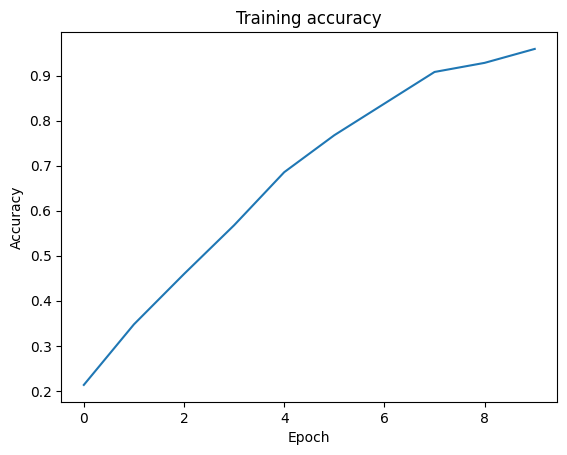

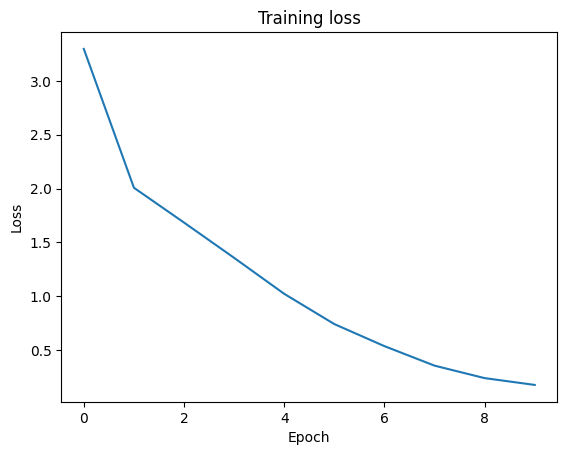

In [14]:
plot_acc(history)
plot_loss(history)

## Testing

In [15]:
result = model.evaluate(x_test, y_test, batch_size=32)

12/12 [==============================] - 1s 65ms/step - loss: 3.2169 - accuracy: 0.2861
